In [1]:
import h5py as h5
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K
import gc
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices[0])

2.0.0
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
filenames = {
    "herwig": "GAN-data\events_anomalydetection_DelphesHerwig_qcd_features.h5",
    "pythiabg": "GAN-data\events_anomalydetection_DelphesPythia8_v2_qcd_features.h5",
    "pythiasig": "GAN-data\events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5"
}

datatypes = ["herwig", "pythiabg", "pythiasig"]

features = ["px", "py", "pz", "m", "tau1", "tau2", "tau3"]

train_features = ["tau21j2"]

In [3]:
def load_data(datatype, stop = None):
    input_frame = pd.read_hdf(filenames[datatype], stop = stop)
    output_frame = input_frame.copy()
    for feature in features:
        output_frame[feature + "j1"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j1"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j2"]
        output_frame[feature + "j2"] = (input_frame["mj1"] >= input_frame["mj2"])*input_frame[feature + "j2"] + (input_frame["mj1"] < input_frame["mj2"])*input_frame[feature + "j1"]
    del input_frame
    gc.collect()
    output_frame["ej1"] = np.sqrt(output_frame["mj1"]**2 + output_frame["pxj1"]**2 + output_frame["pyj1"]**2 + output_frame["pzj1"]**2)
    output_frame["ej2"] = np.sqrt(output_frame["mj2"]**2 + output_frame["pxj2"]**2 + output_frame["pyj2"]**2 + output_frame["pzj2"]**2)
    output_frame["ejj"] = output_frame["ej1"] + output_frame["ej2"]
    output_frame["pjj"] = np.sqrt((output_frame["pxj1"] + output_frame["pxj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2 + (output_frame["pyj1"] + output_frame["pyj2"])**2)
    output_frame["mjj"] = np.sqrt(output_frame["ejj"]**2 - output_frame["pjj"]**2)
    output_frame["tau21j1"] = output_frame["tau2j1"] / output_frame["tau1j1"]
    output_frame["tau32j1"] = output_frame["tau3j1"] / output_frame["tau2j1"]
    output_frame["tau21j2"] = output_frame["tau2j2"] / output_frame["tau1j2"]
    output_frame["tau32j2"] = output_frame["tau3j2"] / output_frame["tau2j2"]
    return output_frame

In [4]:
BATCH_SIZE = 256

df = load_data("herwig", BATCH_SIZE*16)

In [5]:
X_train, X_test = train_test_split(df[train_features], test_size = 0.25)
del df
gc.collect()

0

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(X_train)).batch(BATCH_SIZE)

In [7]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())

    model.add(layers.Dense(len(train_features)))
    assert model.output_shape == (None, len(train_features))

    return model

In [8]:
generator = make_generator_model()

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(50, input_shape=(len(train_features),)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(50))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1))

    return model

In [10]:
discriminator = make_discriminator_model()

In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                100       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5

In [12]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                100       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

In [13]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def discriminator_loss(real_output, fake_output):
    return tf.math.subtract(fake_output, real_output)

In [15]:
def generator_loss(fake_output):
    return tf.math.negative(fake_output)

In [16]:
generator_optimizer = tf.keras.optimizers.RMSprop(lr=0.00005)
discriminator_optimizer = tf.keras.optimizers.RMSprop(lr=0.00005, clipnorm = 1.0)

In [17]:
EPOCHS = 10000

In [18]:
# TODO

def K_eval(x):
    try:
        return K.get_value(K.to_dense(x))
    except:
        eval_fn = K.function([], [x])
        return eval_fn([])[0]

In [19]:
@tf.function
def train_step_generator(images, print_losses = False):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    fake_output = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  
  if print_losses:
    tf.print("Generator loss: ", gen_loss, output_stream=sys.stdout)
  
  # losstensor = tf.math.reduce_mean(gen_loss)
  # return K_eval(losstensor)[0]

In [20]:
@tf.function
def train_step_discriminator(images, print_losses = False):
  noise = tf.random.normal([BATCH_SIZE, len(train_features)])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  if print_losses:
    tf.print("Discriminator loss: ", disc_loss, output_stream=sys.stdout)
  
  # losstensor = tf.math.reduce_mean(disc_loss)
  # return tf.keras.backend.get_value(losstensor)[0]

In [21]:
@tf.function
def evaluate_generator(images):
    noise = tf.random.normal([len(images), len(train_features)])
    generated_images = generator(noise, training=True)
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_output = discriminator(len(generated_images), training=True)

    gen_loss = generator_loss(fake_output)

    # losstensor = tf.math.reduce_mean(gen_loss)
    # return tf.keras.backend.get_value(losstensor)[0]

In [22]:
@tf.function
def evaluate_discriminator(images):
    noise = tf.random.normal([len(images), len(train_features)])
    generated_images = generator(noise, training=True)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        real_output = discriminator(len(images), training=True)
        fake_output = discriminator(len(generated_images), training=True)

    disc_loss = discriminator_loss(real_output, fake_output)

    # losstensor = tf.math.reduce_mean(disc_loss)
    # return tf.keras.backend.get_value(losstensor)[0]

In [23]:
def graph_gan(generator):
    fakedata = np.array(generator(tf.random.normal((10000, len(train_features))), training=False))
    plt.title("N-subjettiness ratio")
    plt.ylabel("Normalized to Unity")
    plt.xlabel("$\\tau_{21J_2}$")
    plt.hist(np.array(X_train)[:,0], bins = 25, range = (0, 1), color = "tab:orange", alpha = 0.5, label = "Herwig Background", density = True)
    plt.hist(fakedata, bins = 25, range = (0, 1), color = "tab:blue", histtype = "step", label = "GAN", density = True)
    plt.legend()
    plt.show()

In [24]:
def train(dataset, epochs, n_critic = 5):
  for epoch in tqdm(range(epochs)):
    print_losses = ((epoch + 1) % 1000 == 0)
    draw_outputs = ((epoch + 1) % 1000 == 0)

    if print_losses:
      print()
      print("Epoch " + str(epoch + 1))

    train_gen_loss = 0
    train_disc_loss = 0

    for image_batch in dataset:
      # train_gen_loss += train_step_generator(image_batch, print_losses = print_losses)
      train_step_generator(image_batch, print_losses = print_losses)
      for n in range(n_critic):
        # train_disc_loss += train_step_discriminator(image_batch, print_losses = print_losses)
        train_step_discriminator(image_batch, print_losses = print_losses)
        print_losses = False
    
    # train_gen_losses.append(train_gen_loss / len(dataset))
    # train_disc_losses.append(train_disc_loss / len(dataset) / n_critic)

    # test_gen_losses.append(evaluate_generator(X_test))
    # test_disc_losses.append(evaluate_discriminator(X_test))

    if draw_outputs:
      print()
      print("Epoch " + str(epoch + 1))
      graph_gan(generator)
      # graph_genloss()
      # graph_discloss()

In [25]:
def graph_genloss():
    plt.title("Generator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_gen_losses, fmt='.-b')
    plt.plot(test_gen_losses, fmt='.-r')
    plt.show()

In [26]:
def graph_discloss():
    plt.title("Discriminator Loss")
    plt.ylabel("Wasserstein Loss")
    plt.xlabel("Epoch")
    plt.plot(train_disc_losses, fmt='.-b')
    plt.plot(test_disc_losses, fmt='.-r')
    plt.show()

In [27]:
train_gen_losses = []
train_disc_losses = []
test_gen_losses = []
test_disc_losses = []

  0%|          | 0/10000 [00:00<?, ?it/s]WARNING:tensorflow:Layer dense_4 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

 10%|▉         | 999/10000 [02:16<17:34,  8.53it/s]
Epoch 1000
Generator loss:  [[0.161493257]
 [-0.116933629]
 [-0.320958346]
 ...
 [0.0131496908]
 [-0.160293862]
 [0.0514864847]]
Discriminator loss:  [[-0.191733345]
 [0.0104172081]
 [-0.281293392

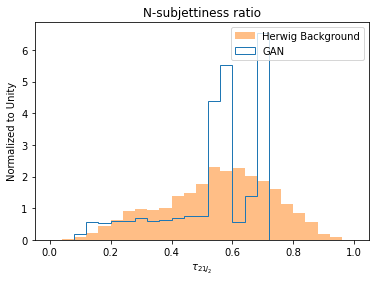

 11%|█         | 1081/10000 [02:27<20:17,  7.32it/s]


KeyboardInterrupt: 

In [28]:
train(train_dataset, EPOCHS, n_critic = 5)